# Modelling the OLG Model

# Introduction

We have chosen to analyze an Overlapping Generations model (**OLG**) with a Pay-As-You-Go (**PAYG**) system. The OLG-model is widely used to study macroeconomic dynamics and economic growth in an economy.

In contrast to e.g., a Ramsey-Cass-Koopman growth model where individuals are infinitely lived, an OLG-model assumes the agents in the economy to be finitely lived. That is, agents live for two "periods". This makes the model a bit more realistic from our point of view, and therefore also more interesting to analyze.

We employ the OLG-model to find the steady-state values of savings and capital accumulation, as well as the agents' intertemporal substitution elasticity expressed throught the Euler-equation 

Imports and set magics:

In [1]:
from types import SimpleNamespace
from scipy import optimize
import numpy as np
import sympy as sm
import matplotlib.pyplot as plt
import ipywidgets as widgets

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2



# Model description

We consider an OLG economy where identical competitive firms maximize their profits:

$$
\begin{aligned}
\pi_t & =\max_{K_{t},L_t} AK_t^\alpha L_t^{1-\alpha}-r_tK_t-w_tL_t\\
k_t & =\frac{K_t}{L_t} 
\end{aligned}
$$

We use, that 
$$
\begin{aligned}
r_t & = \alpha A k_t^{\alpha-1} \\
w_t & = (1-\alpha) A k_t^{\alpha}
\end{aligned}
$$

**Demographics:** Population is constant, so $L_t=L_{t+1}$. A life consists of
two periods, *young* and *old*.

**Households:** Utility for the young households is:
    
$$
\begin{aligned}
U_t & = \log(c_{1t})+\frac{1}{1+\rho} \log(c_{2t+1})\\
\end{aligned}
$$

With the following budget constraints for a Pay As You Go (PAYG) system:
$$
\begin{aligned}
c_{1t} & = (1-\tau)w_t-s_t
\\
c_{2t+1} & = (1+r_{t+1})s_t+w_{t+1}\tau
\end{aligned}
$$

Budget constraints for fully funded (FF) system:
$$
\begin{aligned}
c_{1t} & = (1-\tau)w_t-s_t
\\
c_{2t+1} & = (1+r_{t+1})(s_t+w_t\tau)
\end{aligned}
$$

**Steady state:**

1. Find Euler equation
2. Find $s_t$ in the Euler equation by inserting the budget constraints, then $r_{t}, r_{t+1}, w_t, w_{t+1}$ and at last isolate $s_t$
3. Find capital per. capita accumulation: $k_{t+1}=(1-\delta)k_t+s_t$
4. In steady state $k_{t+1}=k_{t}=k^{*}$

**Capital:** We assume that the old spend their entrie savings, so $\delta = 1 $.

## Analytical solution for PAYG and FF system

If your model allows for an analytical solution, you should provide here.

You may use Sympy for this. Then you can characterize the solution as a function of a parameter of the model.

To characterize the solution, first derive a steady state equation as a function of a parameter using Sympy.solve and then turn it into a python function by Sympy.lambdify. See the lecture notes for details. 

In [2]:
#define symbols 
alpha = sm.symbols('alpha')
k_t = sm.symbols('k_t')
k_t1 = sm.symbols('k_{t+1}')
k_ss = sm.symbols('k^*')
A = sm.symbols('A')
w_t = sm.symbols('w_t')
w_t1 = sm.symbols('w_{t+1}') 
r_t = sm.symbols('r_{t+1}')
r_t1 = sm.symbols('r_{t+1}')
s_t = sm.symbols('s_t') 
tau = sm.symbols('tau')
c_1t = sm.symbols('c_1t') 
c_2t = sm.symbols('c_{2t+1}') 
rho = sm.symbols('rho') 
lambdaa = sm.symbols('lambda')
U_t = sm.symbols('U_t')

#define rent and wage in period t and t+1
rent_t = alpha*A*k_t**(alpha-1)
rent_t1 = alpha*A*k_t1**(alpha-1)
wage_t = (1-alpha)*A*k_t**alpha
wage_t1 = (1-alpha)*A*k_t1**alpha

**Euler equation:**

In [3]:
#define utility function and budget constraints for PAYG and FF systems
u = sm.log(c_1t) + 1/(1+rho)*sm.log(c_2t)
con1 = sm.Eq(c_1t+s_t, (1-tau)*w_t)
con2_payg = sm.Eq(c_2t, (1+r_t1)*s_t+tau*w_t1)
con2_FF = sm.Eq(c_2t, (1+r_t1)*s_t+(1+r_t1)*tau*w_t)

#isolate s_t in con2 and substitute it into con1, so we end up with one budget constraint for both systems
st_con2_PAYG = sm.solve(con2_payg, s_t)
st_con2_FF = sm.solve(con2_FF, s_t)
con1_sub_PAYG = con1.subs(s_t, st_con2_PAYG[0])
con1_sub_FF = con1.subs(s_t, st_con2_FF[0])

# Move right side of budget constraint to the left side for both systems
con_final_PAYG = sm.solve(con1_sub_PAYG, (1-tau)*w_t)[0] - (1-tau)*w_t
con_final_FF = sm.solve(con1_sub_FF, (1-tau)*w_t)[0] - (1-tau)*w_t


#Define lagrangian function with u and con_final for both systems
lagrangian_func_PAYG = u - lambdaa*con_final_PAYG
lagrangian_func_FF = u - lambdaa*con_final_FF

#Take the derivative wrt. c_1t and c_2t for both lagrangian function
foc1_PAYG = sm.diff(lagrangian_func_PAYG, c_1t)
foc2_PAYG = sm.diff(lagrangian_func_PAYG, c_2t)
foc1_FF = sm.diff(lagrangian_func_FF, c_1t)
foc2_FF = sm.diff(lagrangian_func_FF, c_2t)

#isolate lambda in the derivatives
iso_foc1_PAYG = sm.solve(foc1_PAYG,lambdaa)[0]
iso_foc2_PAYG = sm.solve(foc2_PAYG,lambdaa)[0]
iso_foc1_FF = sm.solve(foc1_FF,lambdaa)[0]
iso_foc2_FF = sm.solve(foc2_FF,lambdaa)[0]

#set the two isolate lamdaa equal to each other for both systems, so we get two Euler equation
euler_PAYG = sm.Eq(iso_foc1_PAYG,iso_foc2_PAYG)
final_euler_PAYG = sm.Eq(c_1t,sm.solve(euler_PAYG,c_1t)[0])
euler_FF = sm.Eq(iso_foc1_FF,iso_foc2_FF)
final_euler_FF = sm.Eq(c_1t,sm.solve(euler_FF,c_1t)[0])

print('Euler equation in the PAYG system:')
final_euler_PAYG

Euler equation in the PAYG system:


Eq(c_1t, c_{2t+1}*(rho + 1)/(r_{t+1} + 1))

In [4]:
print('Euler equation in the FF system:')
final_euler_FF

Euler equation in the FF system:


Eq(c_1t, c_{2t+1}*(rho + 1)/(r_{t+1} + 1))

We see that the Euler equation is the same for both the PAYG and FF system

**Savings $(s_t)$**: From Euler equation


In [5]:
#isolate c_1t and c_2t in budget constraints for both systems and substitute it into Euler equation 
iso_con1 = sm.solve(con1,c_1t)[0]
iso_con2_payg = sm.solve(con2_payg,c_2t)[0]
iso_con2_FF = sm.solve(con2_FF,c_2t)[0]
savings_PAYG = final_euler_PAYG.subs(c_1t,iso_con1).subs(c_2t, iso_con2_payg)
savings_FF = final_euler_FF.subs(c_1t,iso_con1).subs(c_2t, iso_con2_FF)

#isolate s_t in savings for both systems
final_savings_PAYG = sm.Eq(s_t, sm.solve(savings_PAYG,s_t)[0])
final_savings_FF = sm.Eq(s_t, sm.solve(savings_FF,s_t)[0])
print('Savings in the PAYG system:')
final_savings_PAYG

Savings in the PAYG system:


Eq(s_t, (-r_{t+1}*tau*w_t + r_{t+1}*w_t - rho*tau*w_{t+1} - tau*w_t - tau*w_{t+1} + w_t)/(r_{t+1}*rho + 2*r_{t+1} + rho + 2))

We would liked to have a more simplified equation for $s_t$ like 
$$
\begin{aligned}
s_t = \frac{1-\rho}{2+\rho}w_t - \tau \frac{1+\rho}{(2+\rho)(1+r_{t+1})}w_{t+1}
\end{aligned}
$$
, but sympy/python dont do that for us. They are still the same tho, one is just more simplified.

In [6]:
print('Savings in the FF system:')
final_savings_FF

Savings in the FF system:


Eq(s_t, w_t*(-rho*tau - 2*tau + 1)/(rho + 2))

We would again like to have a more simplified equation for $s_t$ like
$$
\begin{aligned}
s_t = (\frac{1}{2+\rho}-\tau)w_t
\end{aligned}
$$
, but sympy/python dont do that for us. They are still the same tho, one is just more simplified. 

**Capital accumulation**: from savings as $k_{t+1}=s_t$ in PAYG and $k_{t+1}=s_t+w_t\tau$ in FF

In [7]:
#substitute s_t with k_t1 in both savings equations
cap_acc_PAYG = sm.Eq(k_t1, sm.solve(savings_PAYG,s_t)[0])
cap_acc_FF = sm.Eq(k_t1, sm.solve(savings_FF,s_t)[0] + tau*w_t)

#substitute w_t, w_t1 and r_t1 with wage_t, wage_t1 and rent_t1 in both of the above equations
sub_cap_acc_PAYG = (((cap_acc_PAYG.subs(w_t,wage_t)).subs(w_t1,wage_t1)).subs(r_t1,rent_t1)).subs(s_t,k_t1)
final_cap_acc_FF = cap_acc_FF.subs(w_t,wage_t)

#isolate k_t1 in sub_cap_acc_PAYG, but sympy can't do it since it did not simplifed final_savings (too complex)
"final_cap_acc_PAYG = sm.solve(sub_cap_acc_PAYG,k_t1)"

#Instead we show
print('almost capital accumulation:')
sub_cap_acc_PAYG



almost capital accumulation:


Eq(k_{t+1}, (-A**2*alpha*k_t**alpha*k_{t+1}**(alpha - 1)*tau*(1 - alpha) + A**2*alpha*k_t**alpha*k_{t+1}**(alpha - 1)*(1 - alpha) - A*k_t**alpha*tau*(1 - alpha) + A*k_t**alpha*(1 - alpha) - A*k_{t+1}**alpha*rho*tau*(1 - alpha) - A*k_{t+1}**alpha*tau*(1 - alpha))/(A*alpha*k_{t+1}**(alpha - 1)*rho + 2*A*alpha*k_{t+1}**(alpha - 1) + rho + 2))

If sympy could have isolated k_t1 in sub_cap_acc, then we would have gotten a very complex edition of 
$$
\begin{aligned}
k_{t+1} = \frac{(1-\alpha)(1-\tau)\alpha}{(2+\rho)\alpha+(1+\rho)(1-\alpha)\tau}A k_t^\alpha 
\end{aligned}
$$
, but they would still be the same.

We will go by the simplified capital accumulation above for the rest of the project

In [8]:
final_cap_acc_PAYG = sm.Eq(k_t1, (1-alpha)*(1-tau)*alpha/((2+rho)*alpha+(1+rho)*(1-alpha)*tau)*A*k_t**alpha)
print('Capital accumulation in the PAYG system:')
final_cap_acc_PAYG

Capital accumulation in the PAYG system:


Eq(k_{t+1}, A*alpha*k_t**alpha*(1 - alpha)*(1 - tau)/(alpha*(rho + 2) + tau*(1 - alpha)*(rho + 1)))

In [9]:
print('Capital accumulation in the FF system:')
final_cap_acc_FF

Capital accumulation in the FF system:


Eq(k_{t+1}, A*k_t**alpha*tau*(1 - alpha) + A*k_t**alpha*(1 - alpha)*(-rho*tau - 2*tau + 1)/(rho + 2))

**Steady State**: From capital accumulation as $k_{t+1}=k_t=k^*$

In [10]:
#substitute k_t1 and k_t with k_ss in both of the capial accumulations
ss_PAYG = (final_cap_acc_PAYG.subs(k_t1,k_ss)).subs(k_t,k_ss)
ss_FF = (final_cap_acc_FF.subs(k_t1,k_ss)).subs(k_t,k_ss)

#isolate k_ss in both of the capial accumulations after the substitution
final_ss_PAYG = sm.Eq(k_ss, sm.solve(ss_PAYG,k_ss)[0])
'final_ss_FF = sm.Eq(k_ss, sm.solve(ss_FF,k_ss)[0])' #No algorithms are implemented to solve equation, so do it in hand
final_ss_FF = sm.Eq(k_ss, (((-rho*tau - 2*tau + 1)/(rho + 2)+tau)*(1-alpha)*A)**(1/(1-alpha)))
print('Steady state in the PAYG system:')
final_ss_PAYG

Steady state in the PAYG system:


Eq(k^*, ((-alpha*rho*tau + alpha*rho - alpha*tau + 2*alpha + rho*tau + tau)/(A*alpha*(alpha*tau - alpha - tau + 1)))**(1/(alpha - 1)))

In [11]:
print('Steady state in the FF system:')
final_ss_FF

Steady state in the FF system:


Eq(k^*, (A*(1 - alpha)*(tau + (-rho*tau - 2*tau + 1)/(rho + 2)))**(1/(1 - alpha)))

## Numerical solution

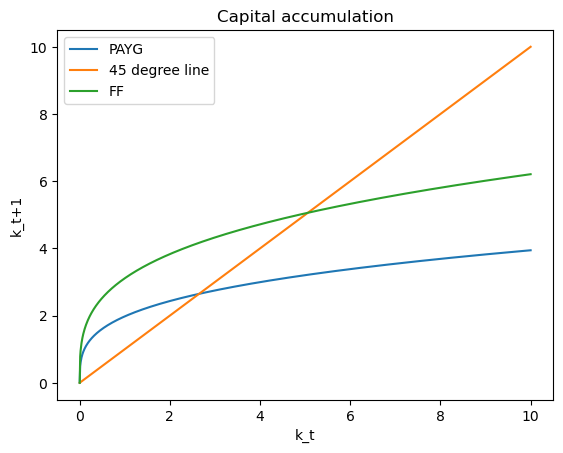

steady state in the PAYG system = 2.647
steady state in the FF system = 5.060


In [12]:
#Define parameters
alpha = 0.3
rho = 0.25
tau = 0.2
n = 0.02
A = 10

#we let $k_t$ be in [0,50]
k_t = np.linspace(0,10, 1000)

#We define the two capital accumulations and steady states
k_t1_PAYG = ((1-alpha)*(1-tau)*alpha)/((2+rho)*alpha+(1+rho)*(1-alpha)*tau)*A*k_t**alpha
ss_k_PAYG = ((-alpha*rho*tau+alpha*rho-alpha*tau+2*alpha+rho*tau+tau)/(A*alpha*(alpha*tau-alpha-tau+1)))**(1/(alpha-1))
k_t1_FF = ((1-rho*tau-2*tau)/(2+rho))*(1-alpha)*A*k_t**alpha+tau*(1-alpha)*A*k_t**alpha
ss_k_FF = (((-rho*tau - 2*tau + 1)/(rho + 2)+tau)*(1-alpha)*A)**(1/(1-alpha))

#Create plot
plt.plot(k_t,k_t1_PAYG, label='PAYG')
plt.plot(k_t,k_t, label='45 degree line')
plt.plot(k_t,k_t1_FF, label='FF')
plt.title('Capital accumulation')
plt.ylabel('k_t+1')
plt.xlabel('k_t')
plt.legend()
plt.show()

#calulate the two steady states
print(f'steady state in the PAYG system = {ss_k_PAYG:.3f}')
print(f'steady state in the FF system = {ss_k_FF:.3f}')

We see that there a bigger accumulation of capital per capita in the Fully Funded system then in the PAY-AS-YOU-GO system, which result in a higher steady state per capita in the Fully Funded system then in a the PAY-AS-YOU-GO system. This happends because in the fully funded system contributions from the young households is invested in capital in period t, and then in period t+1, when they are the old households, they receive their contribution with interest. In contrast to the PAY-AS-YOU-GO system, where the contributions from the young households are not involved with capital/investing, but instead are dicretely giving to the old households in the same period.

In [13]:

def plot(alpha=1/3, tau = 0.2, rho = 0.25, A = 10):  
    alpha = alpha
    tau = tau
    rho = rho
    k_t = np.linspace(0,50, 1000)
    k_t1 = ((1-alpha)*(1-tau)*alpha)/((2+rho)*alpha+(1+rho)*(1-alpha)*tau)*A*k_t**alpha
    
    ss_k = ((-alpha*rho*tau+alpha*rho-alpha*tau+2*alpha+rho*tau+tau)/(A*alpha*(alpha*tau-alpha-tau+1)))**(1/(alpha-1))
    diff_arr = np.absolute(k_t - ss_k)
    index = diff_arr.argmin()
    x_val = k_t[index]
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    ax1.scatter(x_val, ss_k)
    ax1.plot(k_t,k_t1, label='PAYG')
    ax1.plot(k_t,k_t, label='45 degree line')
    plt.title('Capital accumulation for different values of tau')
    ax1.set_xlabel("$k_t$")
    ax1.set_ylabel("$k_{t+1}$")
    ax1.legend()
    ax1.set_xlim(0, 8)
    ax1.set_ylim(0, 8)
    plt.show()
    
def plot_interact():
    widgets.interact(plot,
                
                 alpha=widgets.FloatSlider(
                     description="alpha", min=0.1, max=1, step=0.10, value=1/3),
                 tau=widgets.FloatSlider(
                     description="tau", min=0.1, max=1, step=0.1, value=0.2),
                 rho=widgets.FloatSlider(
                     description="rho", min=0.1, max=1, step=0.1, value=0.25),
                 A=widgets.FloatSlider(
                     description="A", min=0, max=20, step=2, value=10)

    );



You can always solve a model numerically. 

Define first the set of parameters you need. 

Then choose one of the optimization algorithms that we have gone through in the lectures based on what you think is most fitting for your model.

Are there any problems with convergence? Does the model converge for all starting values? Make a lot of testing to figure these things out. 

# Further analysis

**Extension of the OLG model: Population growth**

We new make a extension to our OLG model, so population is no longer constant, but instead growing. The population grows constant with n for every period, so $L_{t+1}=(1+n)L_t$.

Capital accumulation with population growth is in

PAYG system: $k_{t+1}(1+n)=(1-\delta)k_t+s_t$ 

FF system: $k_{t+1}(1+n)=(1-\delta)k_t+s_t+w_t\tau$

,but we do still assume that the old spend their entrie savings, so $\delta = 1 $.

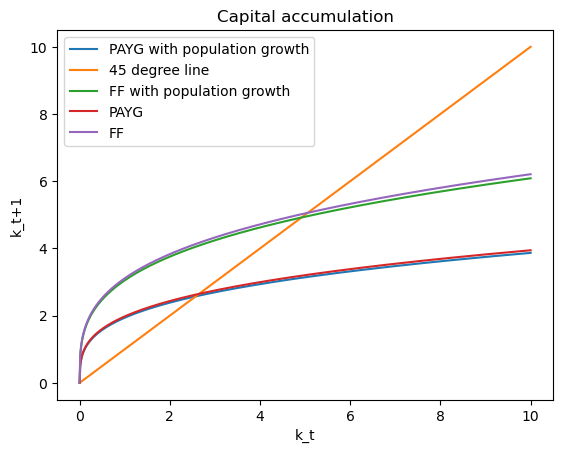

In [14]:
#We define the capital accumulation in both systems after the extension
ex_k_t1_PAYG = (1/(1+n))*(((1-alpha)*(1-tau)*alpha)/((2+rho)*alpha+(1+rho)*(1-alpha)*tau)*A*k_t**alpha)
ex_k_t1_FF = (1/(1+n))*(((1-rho*tau-2*tau)/(2+rho))*(1-alpha)*A*k_t**alpha+tau*(1-alpha)*A*k_t**alpha)

plt.plot(k_t,ex_k_t1_PAYG, label='PAYG with population growth')
plt.plot(k_t,k_t, label='45 degree line')
plt.plot(k_t,ex_k_t1_FF, label='FF with population growth')
plt.plot(k_t,k_t1_PAYG, label='PAYG')
plt.plot(k_t,k_t1_FF, label='FF')
plt.title('Capital accumulation')
plt.ylabel('k_t+1')
plt.xlabel('k_t')
plt.legend()
plt.show()

We can see that after we extend our OLG model with population growth the accumulation of capital per capita becomes lower in both systems, which results in a lower steady state per capita in both systems. This happends because a bigger population hollows out the total capital, which results in a lower level of capital per capita

**Capital accumulation and steady state with different parameter-values (focus on tau)**

In [17]:
#Create a interactive figure 
def plot(alpha=0.3, tau = 0.2, rho = 0.25, A = 10, n=0.02):  
    alpha = alpha
    tau = tau
    rho = rho
    n = n
    k_t = np.linspace(0,50, 1000)
    k_t1_PAYG = ((1-alpha)*(1-tau)*alpha)/((2+rho)*alpha+(1+rho)*(1-alpha)*tau)*A*k_t**alpha
    k_t1_FF = ((1-rho*tau-2*tau)/(2+rho))*(1-alpha)*A*k_t**alpha+tau*(1-alpha)*A*k_t**alpha
    ex_k_t1_PAYG = (1/(1+n))*(((1-alpha)*(1-tau)*alpha)/((2+rho)*alpha+(1+rho)*(1-alpha)*tau)*A*k_t**alpha)
    ex_k_t1_FF = (1/(1+n))*(((1-rho*tau-2*tau)/(2+rho))*(1-alpha)*A*k_t**alpha+tau*(1-alpha)*A*k_t**alpha)
    fig = plt.figure()
    ax1 = fig.add_subplot(1,1,1)
    ax1.plot(k_t,k_t1_PAYG, label='PAYG')
    ax1.plot(k_t,ex_k_t1_PAYG, label='PAYG with pop. growth')
    ax1.plot(k_t,k_t1_FF, label='FF')
    ax1.plot(k_t,ex_k_t1_FF, label='FF with pop. growth')
    ax1.plot(k_t,k_t, label='45 degree line')
    plt.title('Capital accumulation for different parameter-values')
    ax1.set_xlabel("$k_t$")
    ax1.set_ylabel("$k_{t+1}$")
    ax1.legend()
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)
    plt.show()
    
def plot_interact():
    widgets.interact(plot,
                
                 alpha=widgets.FloatSlider(
                     description="alpha", min=0.1, max=1, step=0.05, value=0.3),
                 tau=widgets.FloatSlider(
                     description="tau", min=0.1, max=1, step=0.05, value=0.2),
                 rho=widgets.FloatSlider(
                     description="rho", min=0.1, max=1, step=0.05, value=0.25),
                 A=widgets.FloatSlider(
                     description="A", min=0, max=20, step=1, value=10),
                 n=widgets.FloatSlider(
                     description="n", min=0.001, max=0.5, step=0.005, value=0.02)

                    
    );

plot_interact()

interactive(children=(FloatSlider(value=0.3, description='alpha', max=1.0, min=0.1, step=0.05), FloatSlider(va…

# Conclusion

When the contribution, $\tau$ from the young households increase, then capital per. capita in steady state will decrease.
It happens because the increased contribution makes the young households save less and then capital decreses. 